In [1]:
import os
import pandas as pd
from tqdm import tqdm
import vqa_logger 
import logging
from pathlib import Path
import datetime
from common import DAL
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
logger = logging.getLogger(__name__)

In [2]:
df_models = DAL.get_models_data_frame()
df_models = df_models[['class_strategy', 'parameter_count', 'loss_function', 'trainable_parameter_count','activation', 'notes',]]
# 'model_location',
df_scores = DAL.get_partial_scores_data_frame()
df_question_categories = DAL.get_question_categories_data_frame()
df_evaluation_types = DAL.get_evaluation_types_data_frame()

In [3]:
# df_models.tail()

In [48]:
df_scores.tail()
df_scores.loc[120]

,score,evaluation_type,question_category_id
model_id,,,
120,0.000000,2,2
120,0.018950,1,2
120,0.000000,2,3
120,0.036392,1,3
120,0.272000,2,1
120,0.308453,1,1
120,0.058749,2,4
120,0.079858,1,4
120,0.000000,3,2


In [5]:
# df_question_categories

In [6]:
# df_evaluation_types

In [46]:
df = df_models.join(df_scores, how='inner')\
    .join(df_question_categories, on='question_category_id')\
    .join(df_evaluation_types, on='evaluation_type')\
    .sort_index(ascending=False)


df=df[['Category', 'name', 'score','class_strategy',  'loss_function','activation', 'parameter_count','trainable_parameter_count', 'notes']]
df.loc[[120,202],:]
# df.head()


,Category,name,score,class_strategy,loss_function,activation,parameter_count,trainable_parameter_count,notes
120,Abnormality,bleu,0.058749,answers,cosine_proximity,sigmoid,20095104,61492,"post_concat_dense_units: (8, 6);\nOptimizer: R..."
120,Plane,wbss,0.018950,answers,cosine_proximity,sigmoid,20095104,61492,"post_concat_dense_units: (8, 6);\nOptimizer: R..."
120,Plane,bleu,0.000000,answers,cosine_proximity,sigmoid,20095104,61492,"post_concat_dense_units: (8, 6);\nOptimizer: R..."
120,Organ,wbss,0.036392,answers,cosine_proximity,sigmoid,20095104,61492,"post_concat_dense_units: (8, 6);\nOptimizer: R..."
120,Modality,bleu,0.272000,answers,cosine_proximity,sigmoid,20095104,61492,"post_concat_dense_units: (8, 6);\nOptimizer: R..."
120,Modality,wbss,0.308453,answers,cosine_proximity,sigmoid,20095104,61492,"post_concat_dense_units: (8, 6);\nOptimizer: R..."
120,Organ,bleu,0.000000,answers,cosine_proximity,sigmoid,20095104,61492,"post_concat_dense_units: (8, 6);\nOptimizer: R..."
120,Abnormality,wbss,0.079858,answers,cosine_proximity,sigmoid,20095104,61492,"post_concat_dense_units: (8, 6);\nOptimizer: R..."
120,Organ,strict_accuracy,0.000000,answers,cosine_proximity,sigmoid,20095104,61492,"post_concat_dense_units: (8, 6);\nOptimizer: R..."
120,Modality,strict_accuracy,0.272000,answers,cosine_proximity,sigmoid,20095104,61492,"post_concat_dense_units: (8, 6);\nOptimizer: R..."


### Get data from notes:

In [8]:
new_columns_data = \
{'post_concat_dense_units': None,
'Optimizer': None,
# 'loss': None,
'activation': None,
'prediction ': None,
'lstm_units': None,
'batch_size': None,
'epochs': None,
'class weights': False,
'Inputs Attention': False}

In [9]:
def note_to_lines(raw):
    n = raw
    for c in [';']:
        n = n.replace(c, '')
    lines = (l.strip() for l in n.split('\n'))
    lines = [l for l in lines if ': ' in l]
    return lines


raw = df.notes.values[0]
lines = note_to_lines(raw)
# print('\n'.join(lines))

def get_data_from_lines(lines, col_name):
    default_val = new_columns_data[col_name]
    relevant_lines = [l for l in lines if col_name in l]
    assert len(relevant_lines) <=1
    if len(relevant_lines) == 0:
        data = default_val
    else:
        line = relevant_lines[0]
        data_str = line.split(': ')[-1]
        try:
            data = eval(data_str)            
        except:
            data = data_str
        
    return data
print('-'*10)        
for col in new_columns_data:  
    data = get_data_from_lines(lines, col)
    print(f'{col}: {data}')


----------
post_concat_dense_units: (6, 11)
Optimizer: RMSprop
activation: softmax
prediction : answers
lstm_units: 0
batch_size: 32
epochs: 9
class weights: False
Inputs Attention: False


In [10]:
def notes_to_data(notes, col_name):
    lines =note_to_lines(notes)
    data = get_data_from_lines(lines, col_name)
    return data

for col in new_columns_data:  
    data = notes_to_data(raw, col)
    print(f'{col}: {data}')

post_concat_dense_units: (6, 11)
Optimizer: RMSprop
activation: softmax
prediction : answers
lstm_units: 0
batch_size: 32
epochs: 9
class weights: False
Inputs Attention: False


In [11]:
for col in new_columns_data:  
    df[col.replace(' ', '_')] = df.notes.apply(lambda notes: notes_to_data(notes, col))    


In [12]:
print(df.Category.drop_duplicates().values)
print(df.name.drop_duplicates().values)
print(df.post_concat_dense_units.values)

['Organ' 'Plane' 'Abnormality_yes_no' 'Modality' 'Abnormality']
['wbss' 'bleu' 'strict_accuracy']
[(6, 11) (6, 11) (6, 11) ... None None None]


In [13]:
def dense_layers_to_total(dense_str):
    if dense_str is None:
        return 8
    
    try:
        data = eval(str(dense_str))
    except:
        data = 8
    
    if not isinstance(data, int):
        data = sum(data)
    
    return data
        
    

In [14]:
df['total_dens_units'] = df.post_concat_dense_units.apply(dense_layers_to_total).astype(int)

## Plot results

In [15]:
cmaps = [c for c in dir(plt.cm) if not c.startswith('_')] 
try:
    i += 1
except:
    i = 0

cmap = cmaps[i]
# cmap = "Blues"
# cmap = plt.cm.jet
# cmap ='Accent'
cmap = 'Paired'

In [16]:
df.columns

Index(['Category', 'name', 'score', 'class_strategy', 'loss_function',
       'activation', 'parameter_count', 'trainable_parameter_count', 'notes',
       'post_concat_dense_units', 'Optimizer', 'prediction_', 'lstm_units',
       'batch_size', 'epochs', 'class_weights', 'Inputs_Attention',
       'total_dens_units'],
      dtype='object')

In [40]:
category = 'Abnormality'
evaluation = 'strict_accuracy'# 'bleu'
evaluation_idxs = (df.name==evaluation) | (evaluation is None)
category_idx = ((df.Category==category) | (category is None))
cdf = df[evaluation_idxs & category_idx]

print(cdf.columns)
cdf.sort_values(by='score', ascending=False).head(25)

Index(['Category', 'name', 'score', 'class_strategy', 'loss_function',
       'activation', 'parameter_count', 'trainable_parameter_count', 'notes',
       'post_concat_dense_units', 'Optimizer', 'prediction_', 'lstm_units',
       'batch_size', 'epochs', 'class_weights', 'Inputs_Attention',
       'total_dens_units'],
      dtype='object')


,Category,name,score,class_strategy,loss_function,activation,parameter_count,trainable_parameter_count,notes,post_concat_dense_units,Optimizer,prediction_,lstm_units,batch_size,epochs,class_weights,Inputs_Attention,total_dens_units
120,Abnormality,strict_accuracy,0.056,answers,cosine_proximity,sigmoid,20095104,61492,"post_concat_dense_units: (8, 6);\nOptimizer: R...","(8, 6)",RMSprop,answers,0.0,32.0,NaN,False,False,14
68,Abnormality,strict_accuracy,0.052,answers,cosine_proximity,None,20098270,64654,prediction_vector: answers\n question_category...,None,None,None,NaN,NaN,10.0,False,False,8
131,Abnormality,strict_accuracy,0.052,answers,cosine_proximity,sigmoid,20100231,66619,"post_concat_dense_units: (9, 6);\nOptimizer: R...","(9, 6)",RMSprop,answers,0.0,32.0,NaN,False,False,15
145,Abnormality,strict_accuracy,0.052,answers,cosine_proximity,sigmoid,20093301,59685,"post_concat_dense_units: (7, 9, 8);\nOptimizer...","(7, 9, 8)",RMSprop,answers,0.0,32.0,NaN,False,False,24
148,Abnormality,strict_accuracy,0.052,answers,cosine_proximity,sigmoid,20095161,61549,"post_concat_dense_units: (8, 7, 6);\nOptimizer...","(8, 7, 6)",RMSprop,answers,0.0,32.0,NaN,False,False,21
150,Abnormality,strict_accuracy,0.050,answers,cosine_proximity,sigmoid,20095191,61579,"post_concat_dense_units: (8, 9, 6);\nOptimizer...","(8, 9, 6)",RMSprop,answers,0.0,32.0,NaN,False,False,23
152,Abnormality,strict_accuracy,0.050,answers,cosine_proximity,sigmoid,20101890,68276,"post_concat_dense_units: (9, 6, 7);\nOptimizer...","(9, 6, 7)",RMSprop,answers,0.0,32.0,NaN,False,False,22
153,Abnormality,strict_accuracy,0.050,answers,cosine_proximity,sigmoid,20103507,69891,"post_concat_dense_units: (9, 6, 8);\nOptimizer...","(9, 6, 8)",RMSprop,answers,0.0,32.0,NaN,False,False,23
140,Abnormality,strict_accuracy,0.050,answers,cosine_proximity,sigmoid,20093253,59637,"post_concat_dense_units: (7, 6, 8);\nOptimizer...","(7, 6, 8)",RMSprop,answers,0.0,32.0,NaN,False,False,21
134,Abnormality,strict_accuracy,0.050,answers,cosine_proximity,sigmoid,20088141,54525,"post_concat_dense_units: (6, 7, 8);\nOptimizer...","(6, 7, 8)",RMSprop,answers,0.0,32.0,NaN,False,False,21


In [30]:

x_name = 'parameter_count'
y_name = 'trainable_parameter_count'


x_name = 'prediction_'
y_name = 'score'

x_name = 'Category'
y_name = 'score'


x_name = 'epochs'
y_name = 'score'

x_name = 'loss_function'
y_name = 'score'



sizes_name = 'trainable_parameter_count'
sizes_name ='total_dens_units'
# sizes_name ='epochs'
sizes_name = 'batch_size'



columns = list({x_name, y_name, 'notes',sizes_name})
df_plot = cdf[columns]

# df_plot = df_plot.sort_values(by=sizes_name)
df_plot.loc[:,sizes_name] = (1+cdf[sizes_name])/2

# df_plot.loc[: , 'batch_size'] = df_plot.batch_size.fillna(32)
# df_plot.loc[: , 'epochs'] =df_plot.epochs.fillna(10)

print(cmap)
print(len(cdf))
df_plot.sample(5)

c:\local\Anaconda3-4.1.1-Windows-x86_64\envs\vqa\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Paired
107


,notes,batch_size,loss_function,score
110,"post_concat_dense_units: (8, 7, 6);\nOptimizer...",16.5,cosine_proximity,0.000
103,"post_concat_dense_units: (7, 6, 9);\nOptimizer...",16.5,cosine_proximity,0.000
91,"post_concat_dense_units: (8, 7);\nOptimizer: R...",16.5,cosine_proximity,0.000
68,prediction_vector: answers\n question_category...,NaN,cosine_proximity,0.052
99,"post_concat_dense_units: (6, 8, 9);\nOptimizer...",16.5,cosine_proximity,0.000


In [31]:
is_categorial = df_plot.dtypes[x_name] in (object, bool)
is_categorial
# df_plot.dtypes

True

In [32]:
%matplotlib qt  
# wx, gtk, osx, tk #inline
sns.set(style="white", color_codes=True)

size = cdf[sizes_name].values
sizes=(75, 1000) #(min(size), max(size)
if is_categorial:
    jitter=0.02
    ax = sns.stripplot(x=x_name, y=y_name, data=cdf, alpha=.3,sizes=sizes, size=size, jitter=jitter, edgecolor='gray')# size=z,
elif True:
    s_p2 = size **2
    plt.scatter(cdf[x_name], cdf[y_name], s=s_p2, sizes=sizes, c=cdf[x_name], cmap=cmap, alpha=.3, edgecolors="grey", linewidth=2)
else:    
    ax = sns.scatterplot(x=x_name, y=y_name, data=cdf, hue=y_name,  palette=cmap, alpha=.3, edgecolor='gray')#, size=sizes_name, sizes=sizes)
    
sns.despine()
 
# Add titles (main and on axis)
plt.xlabel(x_name.replace('_', ' '))
plt.ylabel(y_name.replace('_', ' '))
category_str = category if category else 'All Categories'
plt.title(f"'{evaluation}' for '{category_str}' (size={sizes_name})", {'fontsize': 18})
 
# plt.show()


Text(0.5, 1.0, "'strict_accuracy' for 'Abnormality' (size=batch_size)")

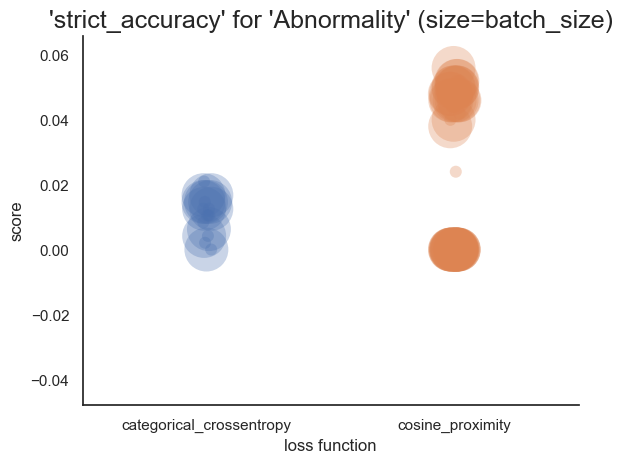

In [21]:
fig = plt.gcf()
plt.rcParams['figure.figsize'] = [20, 10]
fig